# Balance or Edge? - A hockey analysis

Covid-19 cut the 2020 season short for all fans of hockey, myself included. To numb the pain, I decided to crunch the numbers from previous seasons and attempt to answer the age-old question 'Balance or Edge?'.

In short, it's about how to build a winning team. A team with edge has one or a few exceptional players who clearly stand above the rest (think Michael Jordan, Wayne Gretzky or Cristiano Ronaldo), whereas a balanced team tries to recruit players that are fairly close to one another in skill, avoiding obvious superstars. 

"That's silly!", you say. "Obviously, any team should try to recruit the best players possible!" Well, it's not that simple: good players cost good money. The salary of an exceptional player can easily be 4x higher than his average teammate's. What's worth more? 4 average players or 1 exceptional player? See, not so simple after all. 

In this analysis we'll be working with data from the Swedish Hockey League (SHL). I collected it using good-old copy-paste from the [SHL website](https://www.shl.se/statistik/tabell). The data consists of team standings/performance and individual player performance. It spans over the last 20 seasons (2000-2019). 

Before we dig in, to preserve our sanity, let's set a few limits for the analysis:
* We'll work with regular season results only, excluding the playoffs
* We won't look into powerplay or boxplay stats (no worries if these terms are unfamiliar to you)
* We won't look into goalkeepers

Ok, let's get started!

# DATA PREPARATION

In [1]:
# essential imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# loading in the data
teams = pd.read_csv('Teams_2000-2019.csv')
players = pd.read_csv('Players_2000-2019.csv')

In [3]:
# first look at the data
teams

,Season,Rank,Team,GP,3P,2P,1P,0P,G,GA,+/-,Points
0,2019,1,Färjestad,52,28,6,5,13,165,114,51,101
1,2019,2,Luleå,52,25,11,4,12,138,100,38,101
2,2019,3,Frölunda,52,24,8,4,16,152,134,18,92
3,2019,4,Djurgården,52,23,5,7,17,149,120,29,86
4,2019,5,Skellefteå,52,19,10,7,16,142,124,18,84
...,...,...,...,...,...,...,...,...,...,...,...,...
243,2000,8,HV71,50,18,8,5,19,144,131,13,75
244,2000,9,AIK,50,19,5,7,19,151,155,-4,74
245,2000,10,Leksand,50,14,5,7,24,150,174,-24,59
246,2000,11,VIK,50,9,6,4,31,103,196,-93,43


If you're familiar with hockey, you'll have seen these columns many times before. If you're not, the ones that matter right now are:
* Season: denotes the season the following stats are from
* Rank: denotes the regular season rank the team finished on
* Team: the name of the team
* GP: games played throughout the season
* Points: a win gets you 3 points, a loss gets you 0. A draw or overtime loss gets you 1, an overtime win gets you 2. 

Notice that the top rows have GP values or 52, while the bottom rows show 50. This is because the number of games in a season sometimes changes. For easier comparison across seasons, let's introduce the metric Points Per Game (PPG):

In [4]:
teams.loc[:,'PPG'] = teams.loc[:,'Points']/teams.loc[:,'GP']

And now onto the player data:

In [5]:
# first look
players

,Season,Rank,Player,Jersey number,Team,POS,GP,G,A,TP,PIM,GWG,PPG,SOG,HITS,BKS,+,-,+/-,TOI/GP
0,NaN,1,Ryan Lasch,81.0,Frölunda,F,46,12,38,50,18,3,3,83,10,4,31,42,-11,18:35
1,NaN,2,Joakim Lindström,10.0,Skellefteå,F,48,18,24,42,20,5,5,165,5,10,37,28,9,17:33
2,NaN,3,Derek Roy,9.0,Linköping,F,49,8,34,42,28,0,4,92,9,25,34,26,8,17:48
3,NaN,4,Jesse Virtanen,71.0,Färjestad,D,52,6,35,41,47,0,4,85,13,48,42,26,16,22:17
4,NaN,5,Markus Ljungh,16.0,HV71,F,52,16,24,40,8,2,2,98,12,17,39,32,7,18:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8153,NaN,325,Andreas Hadelöv,1.0,Malmö,Gk,49,0,0,0,0,0,0,0,0,0,0,0,0,0:00
8154,NaN,325,Johan Holmqvist,40.0,Brynäs,Gk,49,0,0,0,4,0,0,0,0,0,0,0,0,0:00
8155,NaN,328,Mattias Elm,NaN,Linköping,Gk,50,0,0,0,6,0,0,0,0,0,0,0,0,0:00
8156,NaN,328,Reinhard Divis,38.0,Leksand,Gk,50,0,0,0,8,0,0,0,0,0,0,0,0,0:00


The season column is empty. When I was collecting the data, entering the seasons manually for 8000+ players was a bit too tedious. Let's do it the fast way:

In [6]:
year = 2020
for index, row in players.iterrows():
    if row['Rank'] == 1:
        year -= 1
    players.loc[index,'Season'] = int(year)
players.loc[:,'Season'] = players.loc[:,'Season'].astype(int)

In [7]:
players

,Season,Rank,Player,Jersey number,Team,POS,GP,G,A,TP,PIM,GWG,PPG,SOG,HITS,BKS,+,-,+/-,TOI/GP
0,2019,1,Ryan Lasch,81.0,Frölunda,F,46,12,38,50,18,3,3,83,10,4,31,42,-11,18:35
1,2019,2,Joakim Lindström,10.0,Skellefteå,F,48,18,24,42,20,5,5,165,5,10,37,28,9,17:33
2,2019,3,Derek Roy,9.0,Linköping,F,49,8,34,42,28,0,4,92,9,25,34,26,8,17:48
3,2019,4,Jesse Virtanen,71.0,Färjestad,D,52,6,35,41,47,0,4,85,13,48,42,26,16,22:17
4,2019,5,Markus Ljungh,16.0,HV71,F,52,16,24,40,8,2,2,98,12,17,39,32,7,18:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8153,2000,325,Andreas Hadelöv,1.0,Malmö,Gk,49,0,0,0,0,0,0,0,0,0,0,0,0,0:00
8154,2000,325,Johan Holmqvist,40.0,Brynäs,Gk,49,0,0,0,4,0,0,0,0,0,0,0,0,0:00
8155,2000,328,Mattias Elm,NaN,Linköping,Gk,50,0,0,0,6,0,0,0,0,0,0,0,0,0:00
8156,2000,328,Reinhard Divis,38.0,Leksand,Gk,50,0,0,0,8,0,0,0,0,0,0,0,0,0:00


That's better! 

Once again, there's a ton of columns. The important ones are:
* Season
* Rank: denotes the player's position in that year's point ranking (a 'point' to a hockey player means either a goal or an assist).
* Team
* GP
* TP: total points that season(goals+assists). We'll use this as a metric for a player's offensive skill. 
* "-" (pronounced 'minus'): the number of goals the team conceded with the given player on the ice. We'll use this as a metric for a player's defensive skill. 
* TOI/GP: the average amount of time played per game (in hockey, only 5 out of 22 players play at any given time)

Now let's remove players we don't want for our analysis:




In [8]:
# getting rid of players who played only part of the season (less than 40 games)
players = players.loc[players.loc[:,'GP'] > 40]
# getting rid of players who changed teams during the season
players = players.loc[~players.loc[:,'Team'].str.contains('/')]
# getting rid of goalkeepers
players = players.loc[players.loc[:,'POS'] != 'Gk']

In [9]:
players

,Season,Rank,Player,Jersey number,Team,POS,GP,G,A,TP,PIM,GWG,PPG,SOG,HITS,BKS,+,-,+/-,TOI/GP
0,2019,1,Ryan Lasch,81.0,Frölunda,F,46,12,38,50,18,3,3,83,10,4,31,42,-11,18:35
1,2019,2,Joakim Lindström,10.0,Skellefteå,F,48,18,24,42,20,5,5,165,5,10,37,28,9,17:33
2,2019,3,Derek Roy,9.0,Linköping,F,49,8,34,42,28,0,4,92,9,25,34,26,8,17:48
3,2019,4,Jesse Virtanen,71.0,Färjestad,D,52,6,35,41,47,0,4,85,13,48,42,26,16,22:17
4,2019,5,Markus Ljungh,16.0,HV71,F,52,16,24,40,8,2,2,98,12,17,39,32,7,18:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8043,2000,216,Daniel Larsson,NaN,Leksand,D,41,1,2,3,16,0,0,0,0,0,0,0,0,0:00
8044,2000,217,Johan Åström,NaN,Luleå,F,50,1,2,3,32,0,0,0,0,0,0,0,0,0:00
8047,2000,220,Johan Halvardsson,27.0,HV71,D,46,0,3,3,75,0,0,0,0,0,0,0,0,0:00
8048,2000,220,Reid Simonton,NaN,Frölunda,D,46,0,3,3,66,0,0,0,0,0,0,0,0,0:00


In the bottom right corner we can see a problem. The last few columns have no data. Let's see how many seasons that problem spans over.

In [10]:
players.groupby('Season').mean().loc[:,['+', '-', '+/-']]

,+,-,+/-
Season,,,
2000,0.000000,0.000000,0.000000
2001,0.000000,0.000000,0.000000
2002,0.000000,0.000000,0.000000
2003,0.000000,0.000000,0.000000
2004,0.000000,0.000000,0.000000
2005,0.000000,0.000000,0.000000
2006,0.000000,0.000000,0.000000
2007,24.789744,24.743590,0.046154
2008,24.616915,24.278607,0.338308


Seasons 2000-2006 all lack those columns. I'd prefer not to remove them, but since we'll need the minus column for our defense analysis, we probably need to do that:

In [11]:
players = players.loc[players.loc[:,'Season'] > 2006]
teams = teams.loc[teams.loc[:,'Season'] > 2006]

The time on ice column (TOI/GP) is now in string format - not very useful. Let's convert it into a number:

In [ ]:
def minutes_per_game(time):
    """Converts a time measure from a string with minutes and seconds to a float with minutes only
    
    Parameters:
    time (str): time measure, e.g. '15:30' (15 minutes and 30 seconds)
    
    Returns:
    numeric_time (float): the same amount of time but expressed in minutes only, e.g. 15.5
    """
    minutes_and_seconds = time.split(sep=':')
    minutes = int(minutes_and_seconds[0])
    seconds = int(minutes_and_seconds[1])
    numeric_time = minutes+(seconds/60)
    return numeric_time

players.loc[:,'TOI/GP'] = players.loc[:,'TOI/GP'].apply(minutes_per_game)

The total amount of minutes played over the whole season is likely to come in handy as well:

In [ ]:
players['total_season_minutes'] = players.loc[:,'TOI/GP']*players.loc[:,'GP']

Let's also remove players who don't have a consistent role in the team. A hockey player with a consistent role will usually play between 12 and 20 minutes per game. Let's get rid of those who average less than 10 minutes per game.

In [14]:
players = players.loc[players.loc[:,'TOI/GP'] > 10]

# OFFENSE ANALYSIS

For our offense metric, let's see how many points each player scored per minute played:

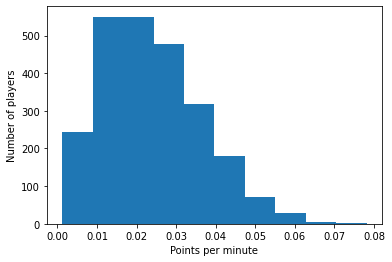

In [15]:
players['points_per_minute'] = players.loc[:,'TP']/players.loc[:,'total_season_minutes']
players['points_per_minute'].hist()
plt.xlabel('Points per minute')
plt.ylabel('Number of players')
plt.grid(False)
plt.show()

Looks like most players score between 0 and 0.04 points per minute, with a few exceptional offensive players reaching above 0.04.

Let's use our new metric to categorize players by their level of offensive skill: low, medium, top. 

In [16]:
def categorize_players_by_skill(metric, new_column, lower_percentile, upper_percentile, reverse = False):
    """Assigns players to a category (low, medium, top) depending on their score in a given metric
    
    Parameters:
    metric (str): the metric used for categorizing players
    new_column (str): the name of the new column that will hold the category value (low/medium/top)
    lower_percentile (float): players below this percentile will be categorized as 'low'
    upper_percentile (float): players above this percentile will be categorized as 'top'
    reverse (bool): used for reversing the percentiles when applying the function to a defensive metric
    where a lower score is better 

    Returns:
    Nothing. The function automatically manipulates the players dataset. 
    """

    if reverse:
        lower_percentile = 1 - lower_percentile
        upper_percentile = 1 - upper_percentile

    # finding the values that correspond to the selected percentiles
    percentile_values = players.loc[:,metric].describe(percentiles=[lower_percentile, upper_percentile])
    cutoff_value_low = percentile_values[4] # players with a lower score than this will be labeled as 'low'
    cutoff_value_top = percentile_values[6] # players with a higher score than this will be labeled as 'top'

    # labeling the players
    players[new_column] = 'medium'

    if reverse:
        players.loc[players.loc[:,metric] > cutoff_value_top, new_column] = 'low'
        players.loc[players.loc[:,metric] < cutoff_value_low, new_column] = 'top'

    else:
        players.loc[players.loc[:,metric] > cutoff_value_top, new_column] = 'top'
        players.loc[players.loc[:,metric] < cutoff_value_low, new_column] = 'low'

Let's assign the bottom 45 % to the "low" category, those in the following 45% range to the "medium" category, and the top 10% to the "top" category:

In [17]:
categorize_players_by_skill('points_per_minute', 'offense_cat', 0.45, 0.90)

In [18]:
players.head()

,Season,Rank,Player,Jersey number,Team,POS,GP,G,A,TP,PIM,GWG,PPG,SOG,HITS,BKS,+,-,+/-,TOI/GP,total_season_minutes,points_per_minute,offense_cat
0,2019,1,Ryan Lasch,81.0,Frölunda,F,46,12,38,50,18,3,3,83,10,4,31,42,-11,18.583333,854.833333,0.058491,top
1,2019,2,Joakim Lindström,10.0,Skellefteå,F,48,18,24,42,20,5,5,165,5,10,37,28,9,17.550000,842.400000,0.049858,top
2,2019,3,Derek Roy,9.0,Linköping,F,49,8,34,42,28,0,4,92,9,25,34,26,8,17.800000,872.200000,0.048154,top
3,2019,4,Jesse Virtanen,71.0,Färjestad,D,52,6,35,41,47,0,4,85,13,48,42,26,16,22.283333,1158.733333,0.035383,medium
4,2019,5,Markus Ljungh,16.0,HV71,F,52,16,24,40,8,2,2,98,12,17,39,32,7,18.000000,936.000000,0.042735,top


Our new features in the last few columns look pretty good! Let's now try a visualization to get a feel for the proportions of medium/top players over the seasons:

In [19]:
def visualize_player_proportions(metric, seasons):
    """Visualizes the proportions of medium and top players for each team in the given seasons.
    
    Parameters:
    metric (str): the metric to visualize proportions of
    seasons (list): the seasons to visualize

    Returns:
    Nothing. The function only produces a visualization. 
    """
        
    fig = plt.figure(figsize=(16,80))

    #colorblindness friendly colors
    cb_dark_blue = (0/255, 107/255, 164/255)
    cb_orange = (255/255, 128/255, 14/255)

    for season in seasons: 
        teams_this_season = teams.loc[teams.loc[:,'Season'] == season]
        teams_by_rank = teams_this_season.loc[:,'Team'].tolist()

        player_count_by_season = players.groupby(['Season', metric, 'Team']).count().loc[season, 'Player']

        medium_count_by_team = player_count_by_season.loc['medium'].reindex(teams_by_rank)
        top_count_by_team = player_count_by_season.loc['top'].reindex(teams_by_rank)

        ax = fig.add_subplot(10,2,season-1999)                                                               
        ax.barh(teams_by_rank, medium_count_by_team, color=cb_dark_blue)
        ax.barh(teams_by_rank, top_count_by_team, left=medium_count_by_team, color=cb_orange)
        ax.invert_yaxis()
        ax.set_ylim(len(teams_by_rank))
        ax.set_xlabel('Number of players')
        ax.legend(labels=['Medium-skilled', 'Top-skilled'],loc='upper left')
        ax.set_title(season)

    plt.show()

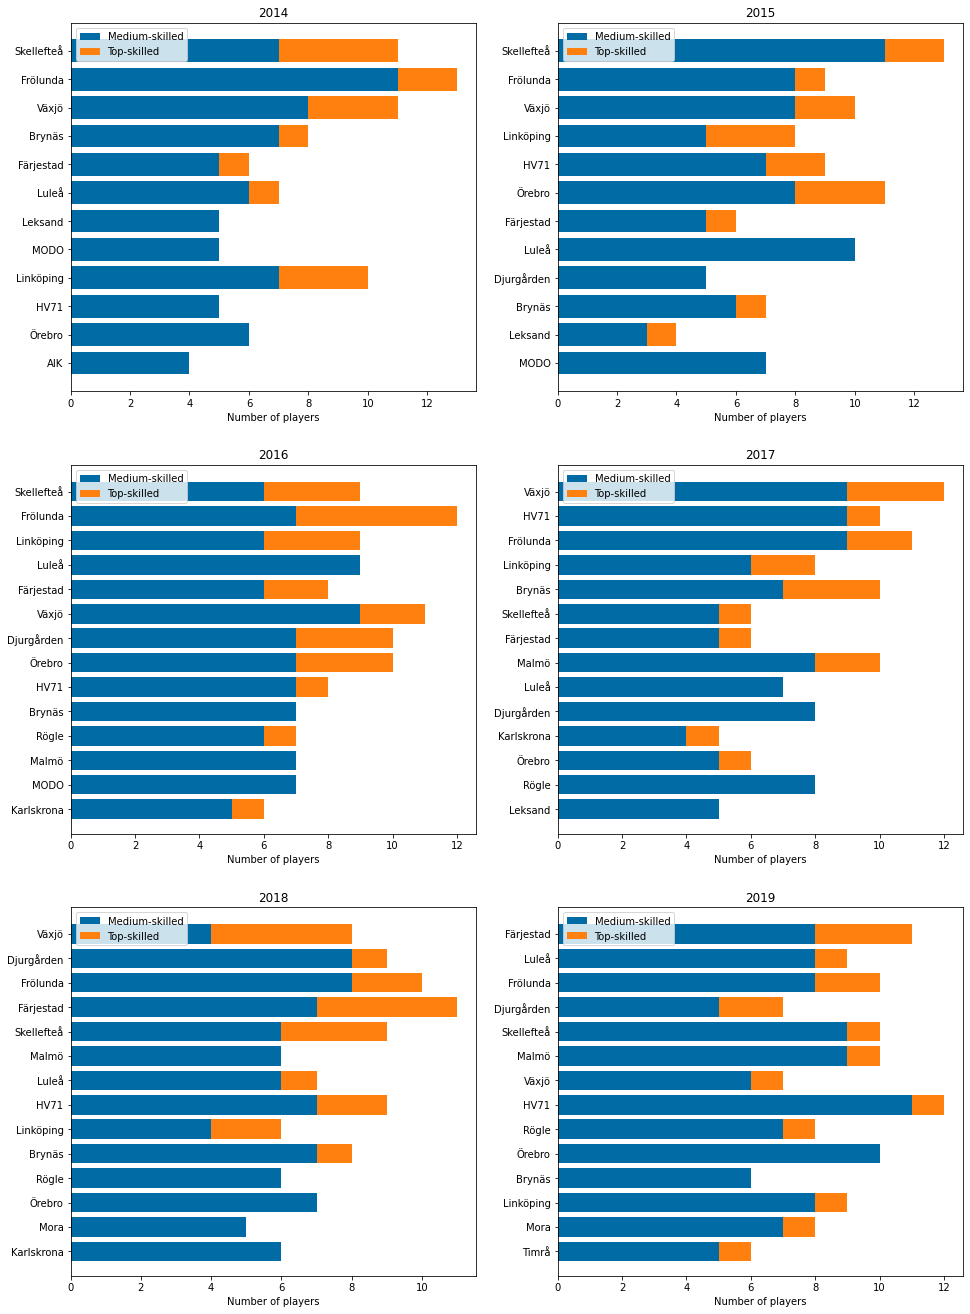

In [20]:
# visualizing the player proportions in the 2014-2019 seasons
visualize_player_proportions('offense_cat', range(2014,2020))

In this sample of 6 seasons, it definitely seems like having a few top-skilled offensive players helps. The upper half of the teams tend to have at least 10% top-skilled offensive players, while the bottom half seems to often lack top-skilled players altogether.

Let's summarize all 14 seasons to see if it holds true over time. 

We'll start by filling out the teams DataFrame with the amounts of players of different categories:

In [ ]:
teams.loc[:,'low_offense_count'] = 0
teams.loc[:,'medium_offense_count'] = 0
teams.loc[:,'top_offense_count'] = 0

for season in range(2007,2020):
    player_count_by_season = players.groupby(['Season', 'offense_cat', 'Team']).count().loc[season, 'Player']
    teams_by_rank = teams.loc[teams.loc[:,'Season'] == season, 'Team'].tolist()
    for category in ['low', 'medium', 'top']:
        column_name = category + '_offense_count'
        teams.loc[teams.loc[:,'Season'] == season, column_name] = player_count_by_season.loc[category].reindex(teams_by_rank).tolist()
        teams.loc[:,column_name].fillna(0, inplace=True)

Out of the medium-to-top skilled offensive players, what proportion is top-skilled?

In [ ]:
teams.loc[:,'top_offense_pct'] = teams.loc[:,'top_offense_count']/(teams.loc[:,'top_offense_count']+teams.loc[:,'medium_offense_count'])

Let's take a look at our new features:

In [23]:
teams

,Season,Rank,Team,GP,3P,2P,1P,0P,G,GA,+/-,Points,PPG,low_offense_count,medium_offense_count,top_offense_count,top_offense_pct
0,2019,1,Färjestad,52,28,6,5,13,165,114,51,101,1.942308,4,8,3.0,0.272727
1,2019,2,Luleå,52,25,11,4,12,138,100,38,101,1.942308,7,8,1.0,0.111111
2,2019,3,Frölunda,52,24,8,4,16,152,134,18,92,1.769231,5,8,2.0,0.200000
3,2019,4,Djurgården,52,23,5,7,17,149,120,29,86,1.653846,6,5,2.0,0.285714
4,2019,5,Skellefteå,52,19,10,7,16,142,124,18,84,1.615385,8,9,1.0,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,2007,8,Mora,55,23,0,9,23,147,155,-8,78,1.418182,8,6,3.0,0.333333
160,2007,9,Frölunda,55,22,1,8,24,167,162,5,76,1.381818,5,4,4.0,0.500000
161,2007,10,Djurgården,55,19,5,9,22,146,148,-2,76,1.381818,5,6,2.0,0.250000
162,2007,11,Skellefteå,55,18,6,7,24,139,178,-39,73,1.327273,7,8,0.0,0.000000


Looks good! Let's see how the proportion of top players (edge) in a team affets the team's performance. We'll group teams with similar proportions into bins, and then see how each bin does on average. 

In [24]:
def visualize_performance_by_edge(metric, bins):
    """Visualizes the average performance of teams with similar values in a given metric.
    
    Parameters:
    metric (str): the metric to measure performance by
    bins (int): the number of bins to group teams into before taking the average of the given metric

    Returns:
    Nothing. The function only outputs a table and a visualization. 
    """
    
    edge_binned = teams.groupby(pd.cut(x=teams[metric], bins=bins)).agg(['count', 'mean']).loc[:,['Rank', 'PPG']]
    edge_binned = round(edge_binned.iloc[:,[0,1,3]], 2)
    edge_binned.columns = ['Number of teams', 'Average rank', 'Average PPG']
    edge_binned.reset_index(level=0, inplace = True)
    edge_binned.index = [f'Team bin {i}' for i in range(1,11)]
    display(edge_binned)

    step = teams.loc[:,metric].max()/bins

    fig = plt.figure(figsize=(16,5))

    ax1 = fig.add_subplot(1,2,1)
    ax1.plot([round(step*i,2) for i in range(bins)], edge_binned.loc[:,'Average rank'])
    ax1.set_xlabel('Top player proportion ("Edge")')
    ax1.set_ylabel('Regular season rank')
    ax1.set_title('Top player proportion and rank correlation')
    ax1.invert_yaxis()

    ax2 = fig.add_subplot(1,2,2) 
    ax2.plot([round(step*i,2) for i in range(bins)], edge_binned.loc[:,'Average PPG'])
    ax2.set_ylabel('Average points per game')
    ax2.set_xlabel('Top player proportion ("Edge")')
    ax2.set_title('Top player proportion and points correlation')

    plt.show()

    best_proportion_for_rank = edge_binned.sort_values(by='Average rank').iloc[0,0]
    best_proportion_for_points = edge_binned.sort_values(by='Average PPG',ascending = False).iloc[0,0]

    print(f'Most effective proportion for rank: the {best_proportion_for_rank} range')
    print(f'Most effective proportion for points: the {best_proportion_for_points} range')

,top_offense_pct,Number of teams,Average rank,Average PPG
Team bin 1,"(-0.000571, 0.0571]",44,9.70,1.25
Team bin 2,"(0.0571, 0.114]",23,5.13,1.58
Team bin 3,"(0.114, 0.171]",26,7.58,1.44
Team bin 4,"(0.171, 0.229]",16,6.12,1.58
Team bin 5,"(0.229, 0.286]",20,6.35,1.52
Team bin 6,"(0.286, 0.343]",15,5.60,1.62
Team bin 7,"(0.343, 0.4]",5,2.40,1.80
Team bin 8,"(0.4, 0.457]",8,3.88,1.69
Team bin 9,"(0.457, 0.514]",5,4.00,1.78
Team bin 10,"(0.514, 0.571]",2,4.00,1.62


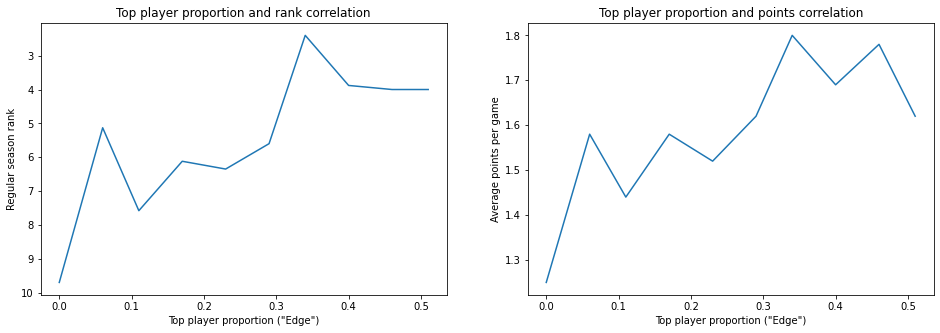

Most effective proportion for rank: the (0.343, 0.4] range
Most effective proportion for points: the (0.343, 0.4] range


In [25]:
visualize_performance_by_edge('top_offense_pct', 10)

Well, over 14 seasons there is definitely a correlation between offensive edge and team performance. Up until the 34-40% range, teams with more offensive edge do better, but when the proportion goes higher than that, performance starts to decline.  

# DEFENSE

Does the same hold true for defense? Let's see!

We're going to use the opposite metric from the offense analysis: how many goals were conceded (scored by the other team) while the given player was on the ice? This data is in the minus column. Let's use a per-minute metric again:

In [26]:
players.loc[:,'minus_per_minute'] = players.loc[:,'-']/players.loc[:,'total_season_minutes']

Let's categorize with the same percentiles as in the offense analysis:

In [27]:
categorize_players_by_skill('minus_per_minute', 'defense_cat', 0.45, 0.90, reverse=True)

And once again, let's add the number of players in different categories to the teams DataFrame:

In [ ]:
teams.loc[:,'low_defense_count'] = 0
teams.loc[:,'medium_defense_count'] = 0
teams.loc[:,'top_defense_count'] = 0

In [ ]:
for season in range(2007,2020):
    player_count_by_season = players.groupby(['Season', 'defense_cat', 'Team']).count().loc[season,'Player']
    teams_by_rank = teams.loc[teams.loc[:,'Season'] == season, 'Team'].tolist()
    for category in ['low', 'medium', 'top']:
        column_name = category + '_defense_count'
        teams.loc[teams.loc[:,'Season'] == season, column_name] = player_count_by_season.loc[category].reindex(teams_by_rank).tolist()
        teams.loc[:,column_name].fillna(0, inplace=True)

And let's take a look at the last 6 seasons. Is there a pattern in the proprotions between medium and top-skilled defensive players?

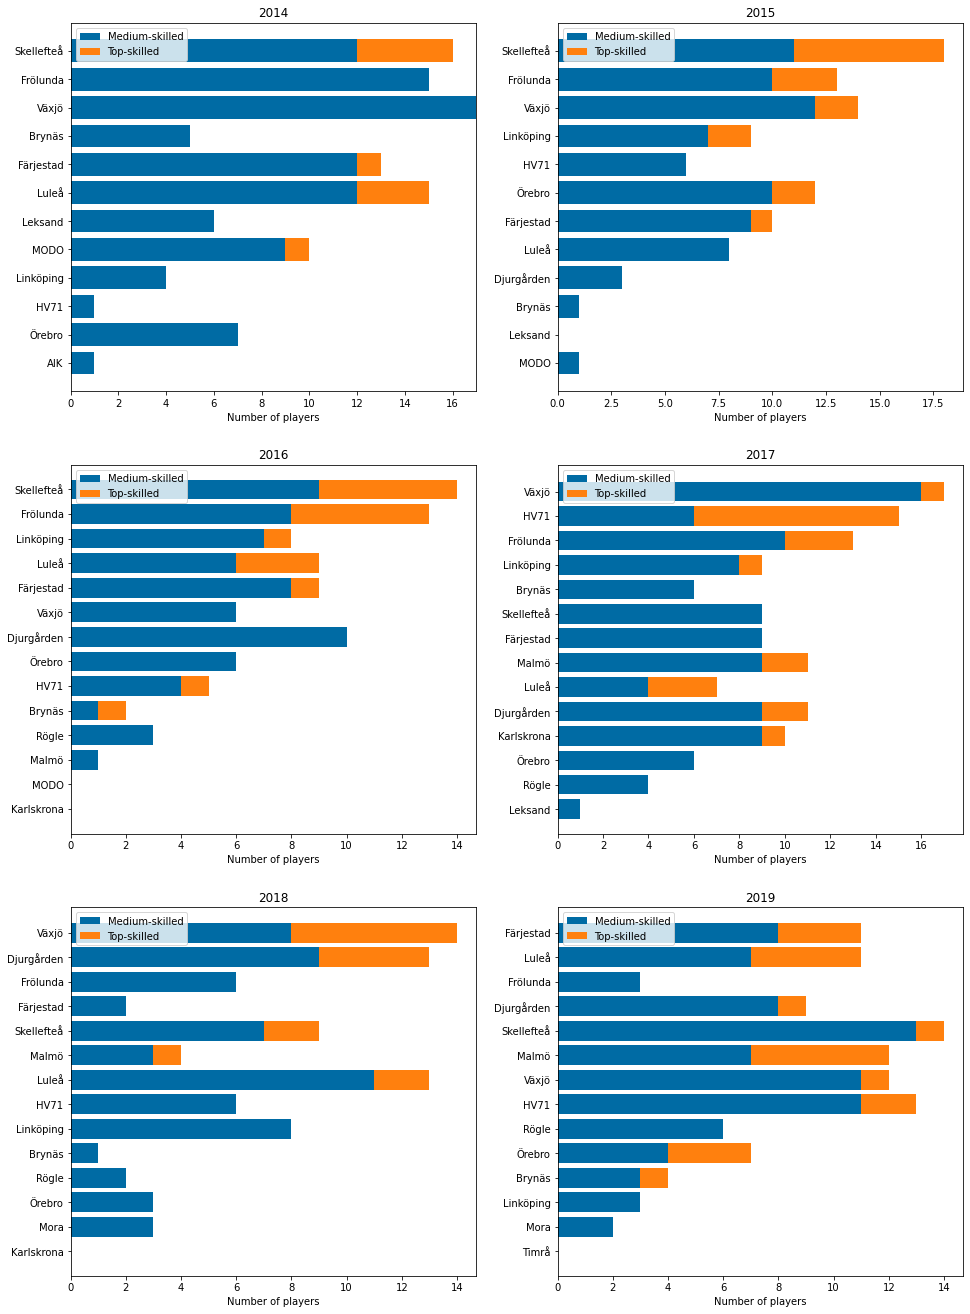

In [30]:
visualize_player_proportions('defense_cat', range(2014,2020))

Interesting! The difference between stronger and weaker teams seems bigger here. Some of the worse teams don't even have a single medium-skilled defenseman. And while the top teams usually have a few top defenders, there are some clear exceptions, like the teams on 2nd-4th place in 2014. The top 2 teams in 2017 also show an opposing pattern.

Let's look at the proportions:

In [ ]:
teams.loc[:,'top_defense_pct'] = teams.loc[:,'top_defense_count']/(teams.loc[:,'top_defense_count']+teams.loc[:,'medium_defense_count'])

,top_defense_pct,Number of teams,Average rank,Average PPG
Team bin 1,"(-0.000667, 0.0667]",73,8.04,1.39
Team bin 2,"(0.0667, 0.133]",25,5.88,1.55
Team bin 3,"(0.133, 0.2]",18,7.17,1.47
Team bin 4,"(0.2, 0.267]",10,4.40,1.70
Team bin 5,"(0.267, 0.333]",10,4.60,1.64
Team bin 6,"(0.333, 0.4]",6,2.83,1.86
Team bin 7,"(0.4, 0.467]",7,5.57,1.65
Team bin 8,"(0.467, 0.533]",7,5.29,1.58
Team bin 9,"(0.533, 0.6]",1,2.00,1.88
Team bin 10,"(0.6, 0.667]",2,4.00,1.70


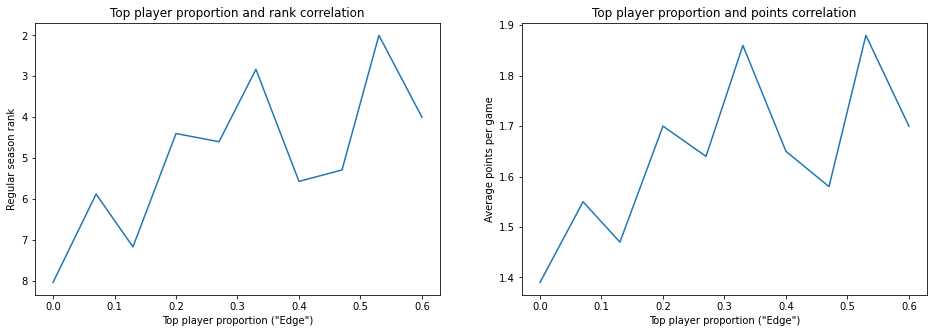

Most effective proportion for rank: the (0.533, 0.6] range
Most effective proportion for points: the (0.533, 0.6] range


In [32]:
visualize_performance_by_edge('top_defense_pct', 10)

The pattern on the defensive side is similar, but not identical. More edge clearly yields better results, but these curves show 2 peaks. There is a strong decline after the 34-40% peak, just like for offensive players, but it soon recovers to a slightly higher peak at the 53-60% range. 

Glancing at the table above the visualizations, however, we can see that the 53-60% bin consists of only one team! Mildly speaking, the data is very limited and we may want to be careful when drawing conclusions. 

Since the 34-40% range yields strong results for both offense and defense, it's safer to stick to when putting together our team. Having reached that number, we'll consider our analysis finished. So is that a definite answer? 34-40% is the best proportion of top players? It's too early to say. There are definitely deeper analyses to be made on this topic, and the only real conclusion I'd draw from it is that if you want to win, you'll need a few top players.  

The reason for not filling our team with 100% top players is of course money. SHL salaries are not public, but [this article](https://www.expressen.se/kvallsposten/sport/blogg/mrmadhawk/2019/01/07/23-shl-spelare-har-offentliga-loner/) provides some insight. An exceptional player can make 200.000-300.000 SEK/month, whereas an average player might make 70.000. A junior player can make as little as 20.000. If you have 200.000 extra/month to spare, are you better off recruiting one exceptional player, or "upgrading" 4 junior players to average players? This anaylsis suggests that for most teams, picking one exceptional player yields better results. If the team already has a top player proportion of >40%, though, bringing more edge might not help. 

Other variables that would be fun to dig into include:
* Players scoring game-winning goals
* Powerplay and boxplay statistics
* Goalkeepers!
* Using clustering techniques to group players into more sophisticated categories. 
* Putting offense and defence together to create one overall metric. 
* Approach the same question not through individual player performance but by *line* performance. In hockey, teams are generally grouped into groups of 5 players who play together, known as lines. 

The most tempting thing would be to include player salaries in the analysis, but for now SHL player salaries are unfortunately not public. 